In [1]:
%matplotlib inline
import random

import gurobipy as gp
from gurobipy import GRB
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn.cluster import MiniBatchKMeans
import datetime as dt

# Tested with Gurobi v9.0.0 and Python 3.7.0

seed = 10101
num_customers = 100
num_candidates = 7
max_facilities = 5
num_clusters = 100
num_gaussians = 10
threshold = 0.99
cust_latlong_dem_actual = pd.read_csv('full_demand_lat_longs.csv')
feasible_lcs = pd.read_excel('Feasible_LC_Locations.xlsx')

In [2]:
feasible_lcs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 239 entries, 0 to 238
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   City    239 non-null    object 
 1   State   239 non-null    object 
 2   Lat     239 non-null    float64
 3   Long    239 non-null    float64
dtypes: float64(2), object(2)
memory usage: 7.6+ KB


In [3]:
facility_locs = feasible_lcs[['Lat','Long']].values

In [4]:
def haversine_distance(loc1, loc2, circuity_factor=1.3):
    """
    Calculate the Haversine distance between two points on the Earth's surface.

    Parameters:
        lat1 (float): Latitude of the first point (in degrees).
        lon1 (float): Longitude of the first point (in degrees).
        lat2 (float): Latitude of the second point (in degrees).
        lon2 (float): Longitude of the second point (in degrees).
        circuity_factor (float): Circuity factor to adjust the distance (default is 1.0).

    Returns:
        float: Haversine distance adjusted by the circuity factor.
    """
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(math.radians, [loc1[0], loc1[1], loc2[0], loc2[1]])

    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = math.sin(dlat / 2) ** 2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = 6371 * c  # Radius of the Earth in kilometers

    # Adjust distance based on circuity factor
    adjusted_distance = distance * circuity_factor*0.621371

    return adjusted_distance

In [5]:
weights = cust_latlong_dem_actual['Weight (lbs)'].values
customer_locs = cust_latlong_dem_actual[['latitude','longitude']].values

In [6]:
pairings = {(facility, cluster): haversine_distance(facility_locs[facility], customer_locs[cluster])
            for facility in range(len(facility_locs))
            for cluster in range(len(customer_locs))}
            #if  dist(facility_locs[facility], centroids[cluster]) < threshold}
            
print("Number of viable pairings: {0}".format(len(pairings.keys())))

Number of viable pairings: 4171028


In [7]:
m = gp.Model("Facility location")

# Decision variables: select facility locations
select = m.addVars(range(len(facility_locs)), vtype=GRB.BINARY, name='select')
# Decision variables: assign customer clusters to a facility location
assign = m.addVars(pairings.keys(), vtype=GRB.BINARY, name='assign')

# Deploy Objective Function
# 0. Total distance
obj = gp.quicksum(weights[cluster]
               *pairings[facility, cluster]
               *assign[facility, cluster]
               for facility, cluster in pairings.keys())
m.setObjective(obj, GRB.MINIMIZE)

# 1. Facility limit
m.addConstr(select.sum() <= max_facilities, name="Facility_limit")

# Testing Freeze certain decision variables to be 1
#for i in range(len(facility_locs)):
#    if i in [5]:  # indices_to_freeze is a list of indices to be frozen at 1
#        select[i].lb = 1  # Set lower bound to 1
#        select[i].ub = 1  # Set upper bound to 1

# 2. Open to assign
m.addConstrs((assign[facility, cluster] <= select[facility]
             for facility, cluster in pairings.keys()),
            name="Open2assign")

# 3. Closest store
m.addConstrs((assign.sum('*', cluster) == 1
             for cluster in range(len(customer_locs))),
            name="Closest_store")

# Find the optimal solution
m.optimize()

Set parameter Username
Academic license - for non-commercial use only - expires 2025-03-04
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[arm] - Darwin 23.2.0 23C71)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 4188481 rows, 4171267 columns and 12513323 nonzeros
Model fingerprint: 0xf4818af8
Variable types: 0 continuous, 4171267 integer (4171267 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-01, 8e+09]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+00]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 0 rows and 0 columns (presolve time = 5s) ...
Presolve removed 0 rows and 0 columns (presolve time = 10s) ...
Presolve removed 0 rows and 0 columns (presolve time = 28s) ...
Presolve time: 28.77s
Presolved: 4188481 rows, 4171267 columns, 12513323 nonzeros
Variable types: 0 c

  89   2.80282196e+10  2.47262169e+10  7.10e-03 5.40e-04  2.45e+02   884s
  90   2.78962462e+10  2.47392361e+10  6.78e-03 5.26e-04  2.34e+02   892s
  91   2.77519000e+10  2.47723567e+10  6.45e-03 5.78e-04  2.20e+02   905s
  92   2.75588506e+10  2.47856314e+10  6.03e-03 6.26e-04  2.05e+02   916s
  93   2.74404892e+10  2.48052055e+10  5.75e-03 6.96e-04  1.95e+02   929s
  94   2.72511800e+10  2.48204281e+10  5.33e-03 7.36e-04  1.80e+02   939s
  95   2.70611656e+10  2.48414541e+10  4.90e-03 8.25e-04  1.64e+02   951s
  96   2.68472658e+10  2.48612560e+10  4.44e-03 8.78e-04  1.47e+02   965s
  97   2.66583593e+10  2.48858992e+10  4.05e-03 9.07e-04  1.31e+02   975s
  98   2.64765888e+10  2.48974813e+10  3.66e-03 1.01e-03  1.16e+02   985s
  99   2.62484951e+10  2.49025307e+10  3.15e-03 1.34e-03  9.89e+01   995s
 100   2.60310049e+10  2.49050962e+10  2.65e-03 1.59e-03  8.27e+01  1007s
 101   2.56570152e+10  2.49063239e+10  1.75e-03 2.05e-03  5.52e+01  1018s
 102   2.50099727e+10  2.49067653e+10 

In [7]:
#select

In [8]:
#assign

In [8]:
all_vars = m.getVars()
values = m.getAttr("X", all_vars)
names = m.getAttr("VarName", all_vars)

#for name, val in zip(names, values):
 #   if val == 1.0:
        #print(f"{name} = {val}")
model_variables = pd.DataFrame({'Variable': names, 'Value': values})

In [9]:
model_variables

,Variable,Value
0,select[0],-0.0
1,select[1],-0.0
2,select[2],-0.0
3,select[3],-0.0
4,select[4],-0.0
...,...,...
4171262,"assign[238,17447]",0.0
4171263,"assign[238,17448]",0.0
4171264,"assign[238,17449]",0.0
4171265,"assign[238,17450]",0.0


In [10]:
# new data frame with split value columns 
splitData = model_variables["Variable"].str.split(",", n=1, expand=True)

# making new column Pos from first part of the split data, 
# also remove front and back brackets if any
model_variables["Facility"] = splitData[0].str.strip()
model_variables['Facility'] = model_variables['Facility'].str.extract(r'(\d+)')

# making new column state from second part of the split data, 
# also remove front and back brackets if any
model_variables["CustomerIndex"] = splitData[1].str.strip("()")
model_variables['CustomerIndex'] = model_variables['CustomerIndex'].str.extract(r'(\d+)')

In [11]:
routes_assigned = model_variables[len(facility_locs):]
routes_assigned.reset_index(drop = True, inplace = True)

routes_assigned['Facility'] = routes_assigned['Facility'].astype(int)
routes_assigned['CustomerIndex'] = routes_assigned['CustomerIndex'].astype(int)
#routes_assigned['CustomerId'] = routes_assigned['CustomerIndex'] + 1

distances = pd.DataFrame.from_dict(pairings, orient = 'index')
distances = distances.reset_index()

routes_assigned = pd.concat([routes_assigned, distances], axis = 1)

/var/folders/2r/tkd0g52s6k35vzy9v1_cn3zh0000gn/T/ipykernel_12612/388758391.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  routes_assigned['Facility'] = routes_assigned['Facility'].astype(int)
/var/folders/2r/tkd0g52s6k35vzy9v1_cn3zh0000gn/T/ipykernel_12612/388758391.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  routes_assigned['CustomerIndex'] = routes_assigned['CustomerIndex'].astype(int)


In [12]:
routes_assigned.rename(columns={'index': 'Pairing', 0: 'Distance_Miles','Value':'Assignment'}, inplace=True)

routes_assigned = routes_assigned.merge(feasible_lcs,how='left',left_on='Facility',right_index=True)

routes_assigned = routes_assigned.merge(cust_latlong_dem_actual,how='left',left_on='CustomerIndex',right_index = True)

routes_assigned.rename(columns={'City': 'LC_City', 'State': 'LC_State','Lat':'LC_Lat',
                                'Long':'LC_Long','latitude':'Cust_Lat','longitude':'Cust_Long',
                               'Weight (lbs)':'DEMAND'}, inplace=True)

routes_assigned = routes_assigned.drop(['Unnamed: 0'], axis = 1)
#routes_assigned = routes_assigned.drop(['CustomerId','LATITUDE_LONGITUDE'], axis = 1)

In [13]:
routes_assigned.head()

,Variable,Assignment,Facility,CustomerIndex,Pairing,Distance_Miles,LC_City,LC_State,LC_Lat,LC_Long,FiveDigitZip,DEMAND,Net Charge,Recipient City,state_code,county_name,Cust_Lat,Cust_Long
0,"assign[0,0]",-0.0,0,0,"(0, 0)",1928.519333,Grand Prairie,TX,32.6871,-97.0208,1013,206.3,62.96,CHICOPEE,MA,Hampden,42.1487,-72.6079
1,"assign[0,1]",-0.0,0,1,"(0, 1)",1937.366770,Grand Prairie,TX,32.6871,-97.0208,1036,899.0,423.09,HAMPDEN,MA,Hampden,42.0648,-72.4318
2,"assign[0,2]",-0.0,0,2,"(0, 2)",1931.952068,Grand Prairie,TX,32.6871,-97.0208,1060,57.3,7.01,Farmingdale,MA,Hampshire,42.3223,-72.6313
3,"assign[0,3]",-0.0,0,3,"(0, 3)",1932.707132,Grand Prairie,TX,32.6871,-97.0208,1075,168.2,35.38,SOUTH HADLEY,MA,Hampshire,42.2375,-72.5811
4,"assign[0,4]",-0.0,0,4,"(0, 4)",1925.479297,Grand Prairie,TX,32.6871,-97.0208,1089,262.9,564.68,Buena Park,MA,Hampden,42.1151,-72.6411


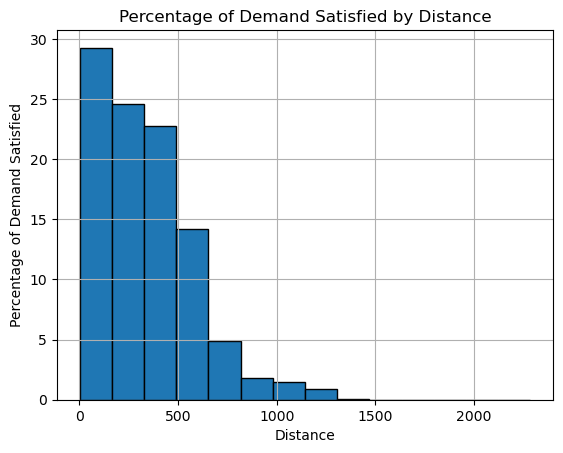

In [14]:
import matplotlib.pyplot as plt

# Sample data
filtered_df = routes_assigned[routes_assigned['Assignment'] == 1.0]
distances = filtered_df['Distance_Miles']  # Distance values
total_demand = sum(filtered_df['DEMAND'])  # Total demand
demands_satisfied = filtered_df['DEMAND']  # Demands satisfied at each distance

# Calculate percentage of demand satisfied at each distance
percentage_satisfied = [(demand / total_demand) * 100 for demand in demands_satisfied]

# Plot as a histogram with 14 bins
plt.hist(distances, bins=14, weights=percentage_satisfied, edgecolor='black')
plt.title('Percentage of Demand Satisfied by Distance')
plt.xlabel('Distance')
plt.ylabel('Percentage of Demand Satisfied')
plt.grid(True)
plt.show()


In [15]:
filtered_df.to_excel('FULL_5LC_Cost.xlsx')

In [18]:
#filtered_df['LC_City'].unique() #old

array(['Grand Prairie', 'Chicago', 'Reno', 'Columbus', 'York'],
      dtype=object)

In [16]:
filtered_df['LC_City'].unique() #new

array(['Chicago', 'Dallas', 'Denver', 'Charlotte', 'Glendale'],
      dtype=object)

In [18]:
filtered_df['LC_State'].unique()

array(['IL', 'TX', 'CO', 'NC', 'CA'], dtype=object)